In [1]:
import sys
import os
import logging
from imp import reload
import numpy as np
import scipy as sc
import seaborn.apionly as sns
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
import sklearn.decomposition as skd
import chianti.core as ch
research_root = '/home/wtb2/Documents/'
sys.path.append(os.path.join(research_root,'solarnmf'))
sys.path.append(os.path.join(research_root,'EBTEL_C/bin/'))
sys.path.append(os.path.join(research_root,'EBTEL_analysis/src/'))
import solarnmf as snf
import ebtel_wrapper as ebw
import ebtel_configure as ebc
import em_binner as emb
reload(snf)
reload(emb)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


 found PyQt4 widgets
 using CLI for selections


/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'em_binner' from '/home/wtb2/Documents/EBTEL_analysis/src/em_binner.py'>

# Event Detection in Forward Modeled Light Curves
Use EBTEL to create synthetic light curves and then use NMF to try and detect the number of events in this light curve.

## EBTEL Run
First, run the EBTEL model for a couple of heating events and get a temperature and density profile.

In [161]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 36000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.1
config_dict['alpha'] = 2.
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 5
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 5e-3
config_dict['sample_rate'] = 100
config_dict['output_file'] = os.path.join(research_root,'research_notebook/NMF/ebtel_light_curve_test')
#set custom start, end times and amplitudes
config_dict['start_time_array'] = np.sort(np.random.normal(config_dict['total_time']/2.,config_dict['total_time']/4.,
                                                  config_dict['num_events']))
config_dict['end_time_array'] = 2.*config_dict['t_pulse_half'] + config_dict['start_time_array']
_configurer = ebc.Configurer(config_dict,'')
config_dict['amp_array'] = _configurer.power_law_dist(np.random.rand(config_dict['num_events']))

In [162]:
#print input file
ebw.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')
#run model
ebw.run_ebtel(os.path.join(research_root,'EBTEL_C/bin/'),'',config_file=config_dict['output_file']+'.xml',verbose=False)

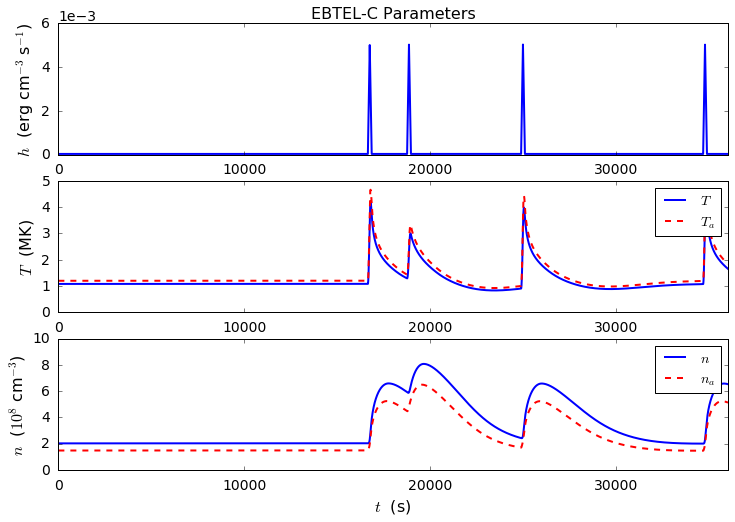

In [163]:
#plot result
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

In [164]:
#Load data
data = np.loadtxt(config_dict['output_file']+'.txt')
t_ebtel = data[:,0]
T_ebtel = data[:,1]
n_ebtel = data[:,2]

## Forward-modeled Light Curve
Now, we want to use the resulting temperature and density to calculate a light curve.

### Differential Emission Measure, $\mathrm{DEM}(T)$

First, calculate the differential emission measure. Here, we'll only use the coronal component which shouldn't be a problem given the temperatures that we care about.

In [165]:
binner = emb.EM_Binner(t_ebtel,T_ebtel,n_ebtel,2.0*config_dict['loop_length']*1.e+8)

In [166]:
binner.build_em_dist()

### Contribution Function, $G(n,T)$
Now we'll use the contribution function as calculated by CHIANTI for Fe XVIII

In [167]:
fe18 = ch.ion('fe_18',temperature=np.logspace(5.5,8,200),eDensity=1.e+9)

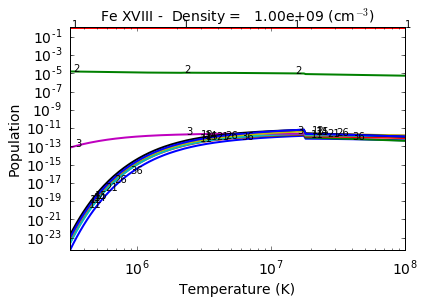

In [168]:
fe18.popPlot()

In [169]:
fe18.intensityList(wvlRange=[90.,95.])

using index =   100 specifying temperature =   5.71e+06, eDensity =    1.00e+09 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
fe_18    28    90      2s2.2p4(1D).3p 2D2.5 - 2s.2p5(1P).3p 2D2.5            90.7763    2.065e-30     2.60e+10 N
fe_18    55   108      2s2.2p4(1D).3d 2P1.5 - 2s.2p5(1P).3d 2D2.5            90.8342    1.634e-30     3.27e+09 N
fe_18    52   104      2s2.2p4(1D).3d 2F2.5 - 2s.2p5(1P).3d 2F3.5            91.0279    1.471e-30     2.06e+09 N
fe_18    29    98      2s2.2p4(1D).3p 2P1.5 - 2s.2p5(1P).3p 2S0.5            91.0411    6.568e-30     8.20e+10 N
fe_18    52   103      2s2.2p4(1D).3d 2F2.5 - 2s.2p5(1P).3d 2F2.5            91.2603    2.159e-30     7.45e+09 N
fe_18    56   108      2s2.2p4(1D).3d 2D2.5 - 2s.2p5(1P).3d 2D2.5            91.3340    1.772e-30     3.57e+09 N
fe_18    54   104      2s2.2p4(1D).3d 2F3.5 - 2s.2p5(1P).3d

 ndens =     1 ntemp =   200
 - make a selection from these - 
     0      91.0411   29   98 2s2.2p4(1D).3p 2P1.5 - 2s.2p5(1P).3p 2S0.5 
     1      91.9888   54  104 2s2.2p4(1D).3d 2F3.5 - 2s.2p5(1P).3d 2F3.5 
     2      93.9322    1    3 2s2.2p5 2P1.5 - 2s.2p6 2S0.5 
 type the comma-separated index/indices of your selection
>>> 2


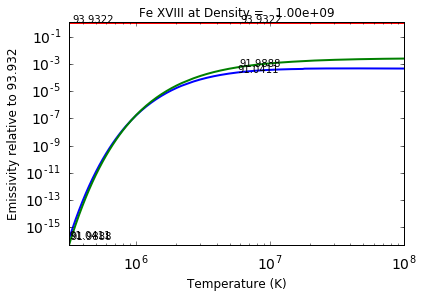

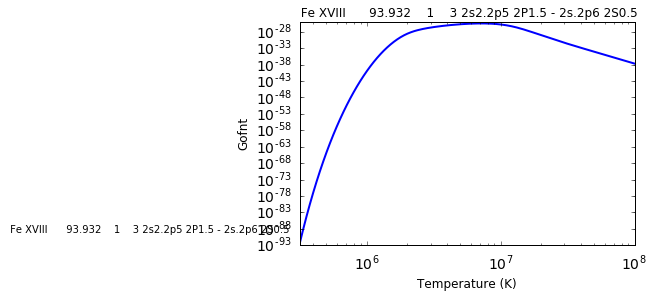

In [170]:
fe18.gofnt(wvlRange=[90,95],top=3)

### Intensity Calculation
First, do some preliminary calculations and allocations.

In [171]:
T_EM = 10**binner.logT_EM
dlogT = binner.logT_EM[1] - binner.logT_EM[0] #assumes uniform spacing
g = np.zeros(len(T_EM))
g_avg = np.zeros(len(t_ebtel))
intensity = np.zeros(len(t_ebtel))
intensity_avg = np.zeros(len(t_ebtel))

In [172]:
ind_g = np.where((T_EM > np.min(fe18.Gofnt['temperature'])) & (T_EM < np.max(fe18.Gofnt['temperature'])))
tck_g = sc.interpolate.splrep(np.log10(fe18.Gofnt['temperature']),np.log10(fe18.Gofnt['gofnt']))
g[ind_g[0]] = 10.**(sc.interpolate.splev(binner.logT_EM[ind_g[0]],tck_g,der=0))

Now, loop over time and calculate the intensity according to the $\mathrm{DEM}$.

In [173]:
for i in range(len(t_ebtel)):
    intensity[i] = np.log(10.)*dlogT*np.sum(g*T_EM*binner.dem_mat[i,:])

Next, calculate the average intensity according to the density $n$ and temperature $T$.

In [174]:
ind_g_avg = np.where((T_ebtel > np.min(fe18.Gofnt['temperature'])) & (T_ebtel < np.max(fe18.Gofnt['temperature'])))
g_avg[ind_g_avg[0]] = 10.**(sc.interpolate.splev(np.log10(T_ebtel[ind_g_avg[0]]),tck_g,der=0))

In [175]:
intensity_avg = n_ebtel**2*g_avg*2.*config_dict['loop_length']*1.e+8

Normalize both intensities.

In [176]:
intensity = intensity/np.max(intensity)
intensity_avg = intensity_avg/np.max(intensity_avg)

## Plot Intensity

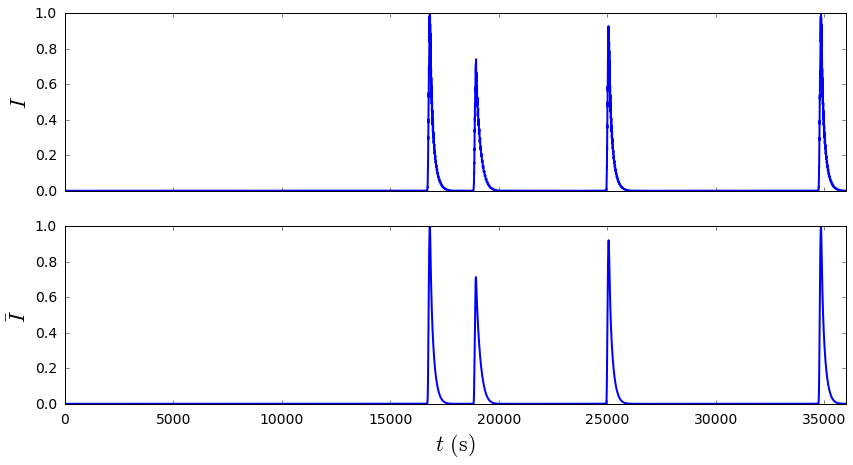

In [177]:
fig,ax = plt.subplots(2,1,figsize=(14,7),sharex=True)
ax[0].plot(t_ebtel,intensity,linewidth=2)
ax[1].plot(t_ebtel,intensity_avg,linewidth=2)
ax[1].set_xlabel(r'$t$ $\mathrm{(s)}$',fontsize=22)
ax[0].set_ylabel(r'$I$',fontsize=22)
ax[1].set_ylabel(r'$\bar{I}$',fontsize=22)
ax[0].set_xlim([t_ebtel[0],t_ebtel[-1]])
ax[1].set_xlim([t_ebtel[0],t_ebtel[-1]])
plt.show()

Now, let's interpolate. Otherwise our NMF matrices will be impossibly large.

In [186]:
tck_I = sc.interpolate.splrep(t_ebtel,intensity_avg)
t_ebtel_short = t_ebtel[0:-1:int(config_dict['t_pulse_half']/10)]
I_short = sc.interpolate.splev(t_ebtel_short,tck_I,der=0)
print(np.shape(I_short))
print(np.shape(t_ebtel_short))

(3600,)
(3600,)


Plot on top of the original intensity to make sure we're not skipping too much.

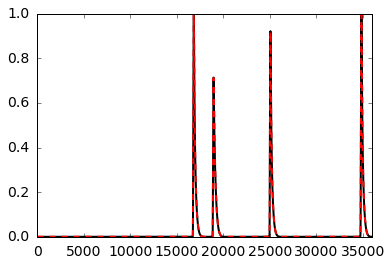

In [187]:
plt.plot(t_ebtel,intensity_avg,'k')
plt.plot(t_ebtel_short,I_short,'--r')
plt.xlim([t_ebtel[0],t_ebtel[-1]])
plt.show()

## Event Detection with NMF

First we need to shape our data into something that the ScikitLearn NMF method can understand.

In [188]:
forwardModel = snf.DataMaker('data','timeseries',angle=45.0,file=I_short)

In [189]:
T,Tmat = forwardModel.make_t_matrix()

Now we'll feed these reshaped matrices into the NMF model.

In [198]:
u_fm,v_fm,n_iter = skd.nmf.non_negative_factorization(Tmat,n_components=20,init='nndsvd',alpha=0.0,
                                                      l1_ratio=0.0,regularization='none')

In [199]:
a_fm = np.dot(u_fm,v_fm)

Next, let's plot the results to see how our reconstruction faired.

In [200]:
fmPlotter = snf.Plotter('data','timeseries',u_fm,v_fm,a_fm,T,angle=45.,Tmat=Tmat)

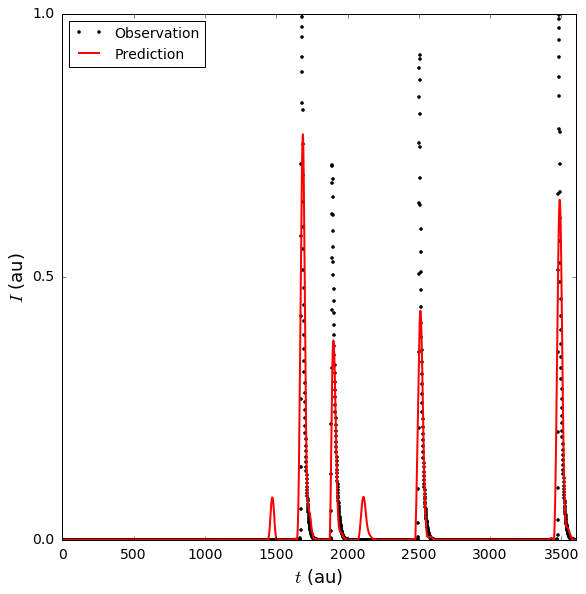

In [201]:
fmPlotter.plot_obs_pred_total()

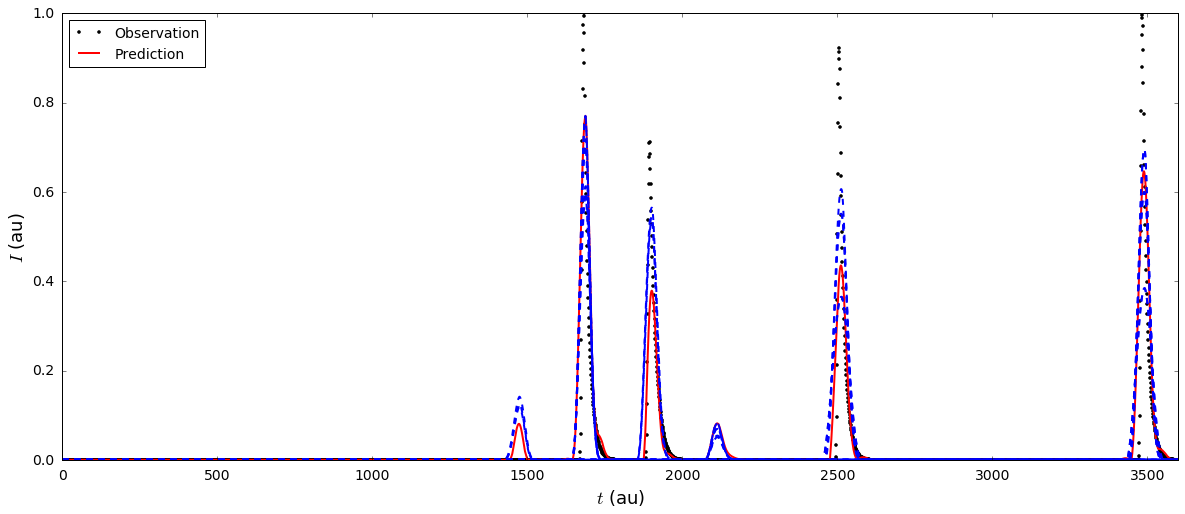

In [202]:
fmPlotter.fig_size=(20,8)
fmPlotter.plot_obs_pred_total_sources_ts()

ERROR:Plotter:Cannot match pairs.
Traceback (most recent call last):
  File "/home/wtb2/Documents/solarnmf/solarnmf/solarnmf_plotting.py", line 167, in plot_obs_pred_sources
    rows = max(self.q,len(self.target))
AttributeError: 'Plotter' object has no attribute 'target'
ERROR:Plotter:Skipping source entry 0, out of range.
Traceback (most recent call last):
  File "/home/wtb2/Documents/solarnmf/solarnmf/solarnmf_plotting.py", line 207, in plot_obs_pred_sources
    ax[i].plot(self.target[pairs[i][0]],'.k',label='source')
AttributeError: 'Plotter' object has no attribute 'target'
ERROR:Plotter:Skipping source entry 1, out of range.
Traceback (most recent call last):
  File "/home/wtb2/Documents/solarnmf/solarnmf/solarnmf_plotting.py", line 207, in plot_obs_pred_sources
    ax[i].plot(self.target[pairs[i][0]],'.k',label='source')
AttributeError: 'Plotter' object has no attribute 'target'
ERROR:Plotter:Skipping source entry 2, out of range.
Traceback (most recent call last):
  File "/home

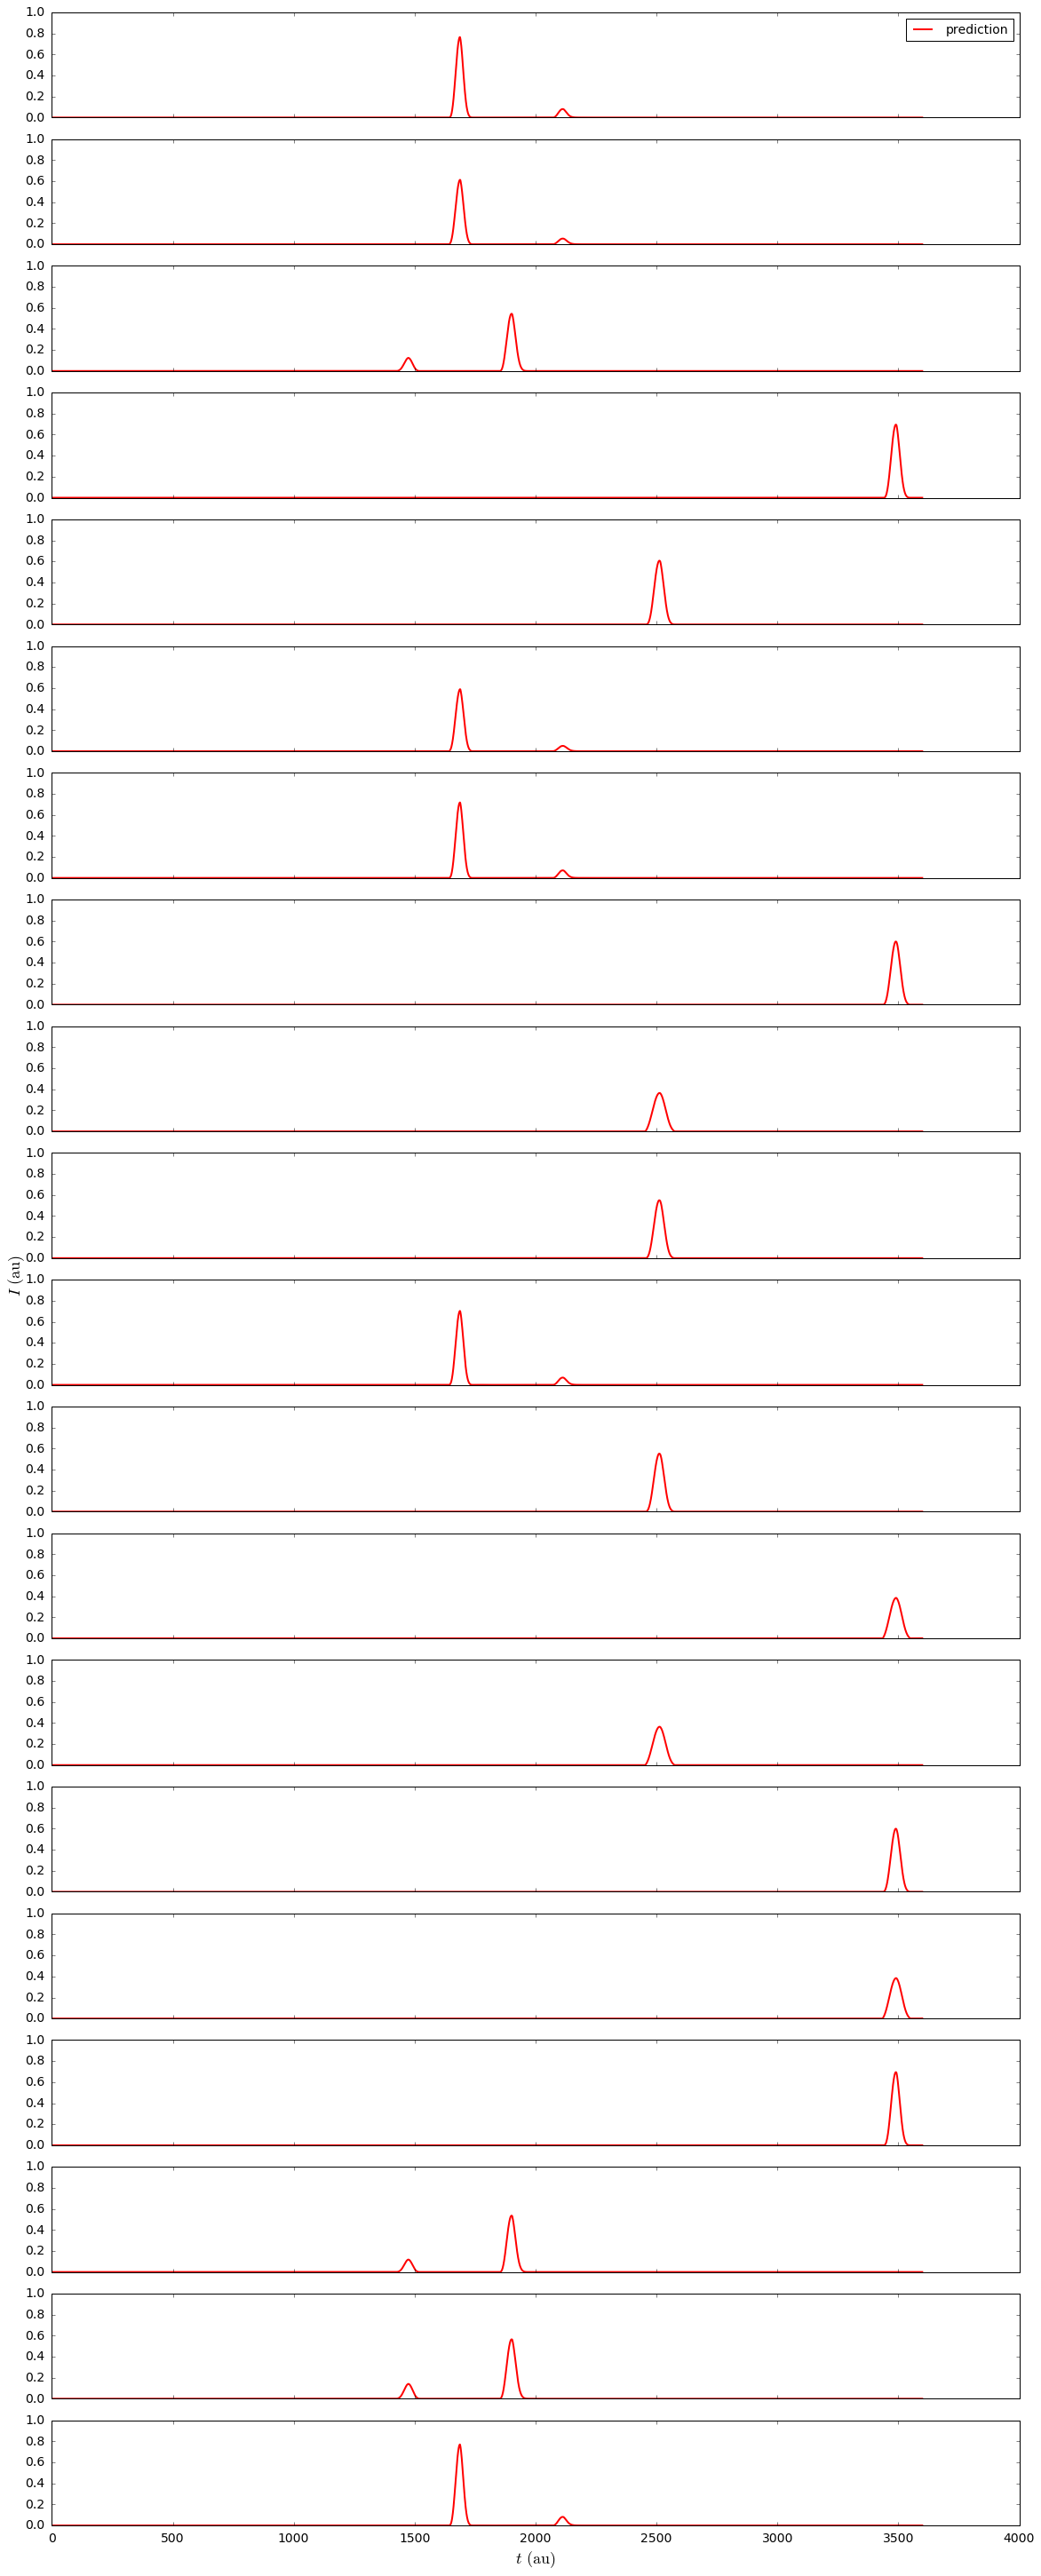

In [204]:
fmPlotter.fig_size = (16,(4*config_dict['num_events'])*2)
fmPlotter.plot_obs_pred_sources()